In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
# Read in data tables
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv',encoding="latin-1")

In [3]:
# Check general form of tables
engagement.head(20)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
print(f'{len(users)} users logged in a total of {len(engagement)} times.')

12000 users logged in a total of 207917 times.


In [6]:
# Let's try completing this one with SQL instead.
engine = create_engine('sqlite:///sqlengine.db')

In [7]:
# Create SQL tables for engagement and users
#engagement.to_sql('engagement',engine)
#users.to_sql('users',engine)

In [8]:
# Confirm that every login counts for only one visit
pd.read_sql('SELECT DISTINCT visited FROM engagement',engine)

,visited
0,1


In [9]:
# This shows that not every user ever logs in on the engagement table
pd.read_sql('SELECT DISTINCT user_id FROM engagement LIMIT 10', engine)

,user_id
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,10
8,11
9,13


In [10]:
# Find users who have logged in at least 3 times
pd.read_sql('SELECT user_id, SUM(visited) AS visits FROM engagement GROUP BY user_id HAVING visits >= 3',engine)

,user_id,visits
0,2,14
1,10,284
2,20,7
3,33,18
4,42,342
...,...,...
2243,11975,216
2244,11980,8
2245,11981,4
2246,11988,30


In [11]:
# Create SQL table containing only users who have logged in at least 3 times
#pd.read_sql('CREATE TABLE active AS SELECT user_id, SUM(visited) AS "visits" FROM engagement GROUP BY user_id HAVING visits >= 3',engine)

In [12]:
pd.read_sql('SELECT * FROM active LIMIT 10',engine)

,user_id,visits
0,2,14
1,10,284
2,20,7
3,33,18
4,42,342
5,43,8
6,50,17
7,53,9
8,59,3
9,60,8


In [13]:
# Total logins by only users who have logged in more than 3 times
total_active_logins = pd.read_sql('SELECT COUNT(*) FROM engagement WHERE user_id IN (SELECT user_id FROM active)',engine).values[0][0]
total_active_logins

201002

In [14]:
# Total users who have logged in more than 3 times
total_active_users = pd.read_sql('SELECT COUNT(DISTINCT(user_id)) FROM active', engine).values[0][0]
total_active_users

2248

In [15]:
# Total logins by all users
total_logins = pd.read_sql('SELECT COUNT(*) FROM engagement',engine).values[0][0]
total_logins

207917

In [16]:
# Total number of users
total_users = pd.read_sql('SELECT COUNT(DISTINCT object_id) FROM users', engine).values[0][0]
total_users

12000

In [17]:
# Number of users who never logged in
inactive_users = pd.read_sql('SELECT COUNT(*) FROM users WHERE object_id NOT IN (SELECT user_id FROM engagement)',engine).values[0][0]
inactive_users

3177

In [18]:
print(f"To sum up, of the {total_logins} total logins by {total_users} total users, {total_active_logins} \
({round(total_active_logins/total_logins*100)}% of logins)\nwere done by the {total_active_users} \
users who had logged in more than 3 times (just {round(total_active_users/total_users*100)}% of users). \n\
In fact, {inactive_users} users ({round(inactive_users/total_users*100)}% of users who created an account) \
never logged in at all!")

To sum up, of the 207917 total logins by 12000 total users, 201002 (97% of logins)
were done by the 2248 users who had logged in more than 3 times (just 19% of users). 
In fact, 3177 users (26% of users who created an account) never logged in at all!


In [19]:
print(f"The average number of logins per user with an account is {round(total_logins/total_users,1)}.")
print(f"The average number of logins per user who logged in at least once is {round(total_logins/(total_users - inactive_users),1)}.")
print(f"The average number of logins per user who logged in at least 3 times is {round(total_active_logins/total_active_users,1)}.")

The average number of logins per user with an account is 17.3.
The average number of logins per user who logged in at least once is 23.6.
The average number of logins per user who logged in at least 3 times is 89.4.


In [20]:
pd.read_sql('SELECT * FROM engagement LIMIT 5', engine)

,index,time_stamp,user_id,visited
0,0,2014-04-22 03:53:30,1,1
1,1,2013-11-15 03:45:04,2,1
2,2,2013-11-29 03:45:04,2,1
3,3,2013-12-09 03:45:04,2,1
4,4,2013-12-25 03:45:04,2,1


In [21]:
# Indexing to make the query run faster
#pd.read_sql('CREATE INDEX idx_time_stamp ON engagement(time_stamp)', engine)
#pd.read_sql('CREATE INDEX idx_user_id ON engagement(user_id)', engine)

In [22]:
# Find logins within one week of each other (for only users who logged in at least 3 times)
query = '''SELECT x.user_id,
x.time_stamp AS first_stamp,
y.time_stamp AS second_stamp
FROM engagement as x 
JOIN engagement as y
ON x.user_id = y.user_id
WHERE x.user_id IN 
(SELECT user_id FROM active)
AND x.time_stamp < y.time_stamp
AND y.time_stamp <= DATE(x.time_stamp, '7 days')'''
with_timestamps = pd.read_sql(query, engine)

In [23]:
# Create a table for logins from active users within a week of each other
#with_timestamps.to_sql('twotimes', engine)

In [24]:
with_timestamps.head()

,user_id,first_stamp,second_stamp
0,2,2013-12-25 03:45:04,2013-12-31 03:45:04
1,2,2014-02-03 03:45:04,2014-02-08 03:45:04
2,2,2014-02-03 03:45:04,2014-02-09 03:45:04
3,2,2014-02-08 03:45:04,2014-02-09 03:45:04
4,2,2014-02-08 03:45:04,2014-02-13 03:45:04


In [25]:
# Find logins from the same users three times within a week--"adopted" users
query = '''SELECT x.user_id, 
x.first_stamp, 
x.second_stamp, 
y.second_stamp AS third_stamp
FROM twotimes AS x
JOIN twotimes AS y
ON x.user_id = y.user_id
WHERE x.second_stamp < y.second_stamp
AND y.second_stamp < DATE(x.first_stamp, '7 days')'''
three_weekly = pd.read_sql(query, engine)

In [26]:
# Create SQL table of these adopted users' logins
#three_weekly.to_sql('adopted',engine)

In [27]:
pd.read_sql('SELECT COUNT(DISTINCT user_id) FROM adopted',engine)

,COUNT(DISTINCT user_id)
0,1602


In [28]:
three_weekly.head()

,user_id,first_stamp,second_stamp,third_stamp
0,2,2014-02-03 03:45:04,2014-02-08 03:45:04,2014-02-09 03:45:04
1,2,2014-02-03 03:45:04,2014-02-08 03:45:04,2014-02-09 03:45:04
2,2,2014-02-08 03:45:04,2014-02-09 03:45:04,2014-02-13 03:45:04
3,2,2014-02-08 03:45:04,2014-02-09 03:45:04,2014-02-13 03:45:04
4,10,2013-02-14 22:08:03,2013-02-17 22:08:03,2013-02-19 22:08:03


In [29]:
three_weekly.tail()

,user_id,first_stamp,second_stamp,third_stamp
6629923,11988,2014-05-24 11:04:47,2014-05-26 11:04:47,2014-05-27 11:04:47
6629924,11988,2014-05-24 11:04:47,2014-05-26 11:04:47,2014-05-27 11:04:47
6629925,11988,2014-05-24 11:04:47,2014-05-26 11:04:47,2014-05-27 11:04:47
6629926,11988,2014-05-26 11:04:47,2014-05-27 11:04:47,2014-06-01 11:04:47
6629927,11988,2014-05-26 11:04:47,2014-05-27 11:04:47,2014-06-01 11:04:47


In [30]:
# Creates a column in the users table to indicate whether they are an adopted user
query = '''ALTER TABLE users 
ADD COLUMN adopted INTEGER'''
# pd.read_sql(query,engine)

In [32]:
# Fills out the adopted users column
query = '''UPDATE users
SET adopted = CASE
WHEN object_id IN 
(SELECT DISTINCT user_id FROM adopted)
THEN 1
ELSE 0
END'''

In [33]:
# pd.read_sql(query, engine)

In [34]:
pd.read_sql('SELECT * FROM users LIMIT 5', engine)

,index,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [35]:
# Double check that it worked
pd.read_sql('SELECT * FROM users WHERE adopted = 1 LIMIT 5', engine)

,index,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
1,9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1
2,19,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1
3,32,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0,1
4,41,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,1


In [36]:
pd.read_sql('SELECT DISTINCT(user_id) FROM adopted LIMIT 5', engine)

,user_id
0,2
1,10
2,20
3,33
4,42


In [37]:
full_users = pd.read_sql('SELECT * FROM users', engine)

In [38]:
# Check for null values
full_users.isna().sum()

index                            0
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                          0
dtype: int64

In [39]:
full_users.dtypes

index                           int64
object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                         int64
dtype: object

In [40]:
# Change last_session_creation_time from a float into a datetime
full_users['last_session_creation_time'] = pd.to_datetime(full_users.last_session_creation_time*1e9)

In [41]:
# Change user id from a float to an int, changing null values to 0
full_users['invited_by_user_id'] = full_users['invited_by_user_id'].fillna(0).astype('int64')

In [42]:
full_users.head(10)

,index,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1
2,2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0
3,3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0
4,4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0
5,5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241,0
6,6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,0
7,7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0,0
8,8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0,0
9,9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143,1


In [43]:
# It seems likely that invited_user_id will not be predictive,
# but whether they were invited by anyone might be 
full_users['invited'] = full_users['invited_by_user_id'] > 0

In [44]:
# Change creation_time into a datetime
full_users['creation_time'] = pd.to_datetime(full_users['creation_time'])

In [45]:
# Create a column for time between account creation and most recent session
full_users['time_active'] = full_users['last_session_creation_time'] - full_users['creation_time']

In [46]:
full_users.head(10)

,index,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,time_active
0,0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,True,0 days
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,True,136 days
2,2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,True,0 days
3,3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,True,1 days
4,4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,True,5 days
5,5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241,0,True,2 days
6,6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,0,False,4 days
7,7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0,0,False,NaT
8,8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0,0,False,NaT
9,9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143,1,True,503 days


In [47]:
full_users.dtypes

index                                   int64
object_id                               int64
creation_time                  datetime64[ns]
name                                   object
email                                  object
creation_source                        object
last_session_creation_time     datetime64[ns]
opted_in_to_mailing_list                int64
enabled_for_marketing_drip              int64
org_id                                  int64
invited_by_user_id                      int64
adopted                                 int64
invited                                  bool
time_active                   timedelta64[ns]
dtype: object

In [48]:
# Create an integer column from the "time active" column, where users who never logged in have -1.
full_users['days_active'] = full_users['time_active'].dt.days.fillna(-1).astype('int64')

In [49]:
full_users.dtypes

index                                   int64
object_id                               int64
creation_time                  datetime64[ns]
name                                   object
email                                  object
creation_source                        object
last_session_creation_time     datetime64[ns]
opted_in_to_mailing_list                int64
enabled_for_marketing_drip              int64
org_id                                  int64
invited_by_user_id                      int64
adopted                                 int64
invited                                  bool
time_active                   timedelta64[ns]
days_active                             int64
dtype: object

In [50]:
full_users.head(10)

,index,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,time_active,days_active
0,0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,True,0 days,0
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,True,136 days,136
2,2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,True,0 days,0
3,3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,True,1 days,1
4,4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,True,5 days,5
5,5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241,0,True,2 days,2
6,6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,0,False,4 days,4
7,7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0,0,False,NaT,-1
8,8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0,0,False,NaT,-1
9,9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143,1,True,503 days,503


In [51]:
# Check each invite source
pd.get_dummies(full_users['creation_source']).sum()

GUEST_INVITE          2163
ORG_INVITE            4254
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
dtype: int64

In [52]:
# Check if I've made a redundant column
pd.get_dummies(full_users[full_users['invited']]['creation_source']).sum()

GUEST_INVITE    2163
ORG_INVITE      4254
dtype: int64

Oops! The "invited" column I made out of the invited_by_user_id column turns out to just be 
a combination of GUEST_INVITE and ORG_INVITE, and does not add new information! 

In [53]:
# Create dummy columns for the categorical variable "creation source"
full_users = full_users.join(pd.get_dummies(full_users['creation_source'],prefix='source',drop_first=True))

In [54]:
full_users.columns

Index(['index', 'object_id', 'creation_time', 'name', 'email',
       'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'invited', 'time_active',
       'days_active', 'source_ORG_INVITE', 'source_PERSONAL_PROJECTS',
       'source_SIGNUP', 'source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

If we include org_id, the model will likely treat it as if they're ordered, when really they're categorical. And there's far too many to One-Hot Encode. We could encode the top organizations and call the other miscellaneous. I've chosen every organization over 90 users, because that's the first 11 organizations in order.

In [55]:
org_counts = full_users['org_id'].value_counts()
top_orgs = (org_counts[org_counts > 90])
top_orgs

org_id
0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
8      97
Name: count, dtype: int64

In [56]:
print(f"The top 11 organizations have {top_orgs.sum()} users, which is \
{round(top_orgs.sum()/len(full_users)*100)}% of users")

The top 11 organizations have 1790 users, which is 15% of users


In [57]:
# Create a variable for whether the user is in one of the top 11 organizations
full_users['top_org'] = full_users.apply(lambda x: x['org_id'] in top_orgs.index, axis=1)

In [58]:
# Find first login day
startday = full_users['creation_time'].min()

In [59]:
# Create column for days between account creation and creation of very first account
full_users['creation_day'] = (full_users['creation_time'] - startday).dt.days.astype('int64')

In [63]:
# Select the columns that seem plausibly predictive
predictive_columns = ['creation_day',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
       'days_active', 'top_org', 'source_ORG_INVITE', 'source_PERSONAL_PROJECTS',
       'source_SIGNUP', 'source_SIGNUP_GOOGLE_AUTH'] 

In [64]:
predictive_columns

['creation_day',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'days_active',
 'top_org',
 'source_ORG_INVITE',
 'source_PERSONAL_PROJECTS',
 'source_SIGNUP',
 'source_SIGNUP_GOOGLE_AUTH']

In [65]:
X = full_users[predictive_columns]
X.head()

,creation_day,opted_in_to_mailing_list,enabled_for_marketing_drip,days_active,top_org,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
0,691,1,0,0,False,False,False,False,False
1,533,0,0,136,True,True,False,False,False
2,292,0,0,0,False,True,False,False,False
3,355,0,0,1,True,False,False,False,False
4,231,0,0,5,False,False,False,False,False


In [66]:
# Create array for target feature
y = full_users['adopted']

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [70]:
# Scale the columns representing days
scaler = StandardScaler()

In [71]:
ct = ColumnTransformer(transformers=[("scaler", StandardScaler(), ['days_active','creation_day'])])

In [73]:
X_train[['days_active','creation_day']] = ct.fit_transform(X_train)

In [75]:
X_test[['days_active','creation_day']] = ct.transform(X_test)

In [76]:
X_train.dtypes

creation_day                  float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
days_active                   float64
top_org                          bool
source_ORG_INVITE                bool
source_PERSONAL_PROJECTS         bool
source_SIGNUP                    bool
source_SIGNUP_GOOGLE_AUTH        bool
dtype: object

In [77]:
X_train.head()

,creation_day,opted_in_to_mailing_list,enabled_for_marketing_drip,days_active,top_org,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
9182,-0.155734,0,0,-0.349331,False,True,False,False,False
11091,0.882731,1,1,-0.349331,False,False,True,False,False
6428,0.771961,0,0,-0.349331,False,False,True,False,False
288,0.841192,1,1,-0.325465,False,False,True,False,False
2626,-0.252657,0,0,-0.309554,False,False,False,False,False


In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [83]:
# Set up sample space for Random Forest hyperparameters
paramgrid = {'bootstrap': [True, False],
 'max_depth': [5, 10, 20, 30, 40, 50, None],
 'max_features': [None, 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 600, 800, 1000]}

In [80]:
forest = RandomForestClassifier(random_state=42)

In [84]:
clf = RandomizedSearchCV(forest, paramgrid, random_state=42,n_iter=20,scoring='f1',verbose=2)

In [ ]:
search = clf.fit(X_train, y_train)

In [86]:
search.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [101]:
forest = RandomForestClassifier(random_state=42,n_estimators=800, min_samples_split=2,
                                min_samples_leaf=4,max_features='sqrt',max_depth=20,bootstrap=True)

In [102]:
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=800,
                       random_state=42)

In [103]:
y_pred = forest.predict(X_test)

In [92]:
from sklearn.metrics import classification_report

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2074
           1       0.94      0.90      0.92       326

    accuracy                           0.98      2400
   macro avg       0.96      0.95      0.95      2400
weighted avg       0.98      0.98      0.98      2400



This is a surprisingly high-scoring model. Let's see where it gets its predictions.

In [107]:
forest_importances = pd.Series(forest.feature_importances_,index=predictive_columns)

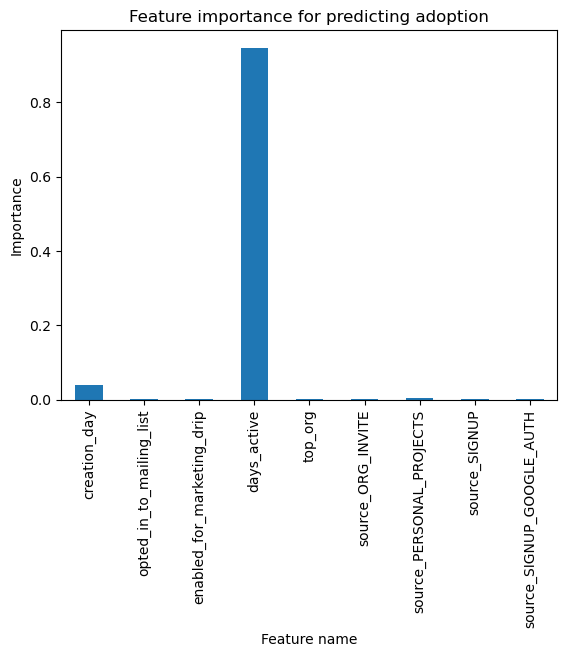

In [110]:
forest_importances.plot(kind='bar')
plt.title('Feature importance for predicting adoption')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.show()

It's a very strong model! But it's almost entirely based on how long the user was active, which doesn't necessarily help us determine whether the user will be active in the *future*.

Let's try it again without taking that into account.

In [114]:
predictive_columns.remove('days_active')

In [117]:
X_train = X_train.drop('days_active',axis=1)
X_test = X_test.drop('days_active',axis=1)

In [119]:
forest2 = RandomForestClassifier(random_state=42)

In [120]:
clf = RandomizedSearchCV(forest2, paramgrid, random_state=42,n_iter=20,scoring='f1',verbose=3)

In [ ]:
search = clf.fit(X_train,y_train)

In [122]:
search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [123]:
forest2 = RandomForestClassifier(random_state=42,n_estimators=1000,min_samples_split=5,
                                 min_samples_leaf=1,max_features='sqrt',max_depth=40,bootstrap=False)

In [124]:
forest2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_split=5,
                       n_estimators=1000, random_state=42)

In [125]:
y_pred = forest2.predict(X_test)

In [126]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2074
           1       0.17      0.13      0.14       326

    accuracy                           0.80      2400
   macro avg       0.52      0.51      0.51      2400
weighted avg       0.77      0.80      0.78      2400



In [129]:
forest2_importances = pd.Series(forest2.feature_importances_,index=predictive_columns)

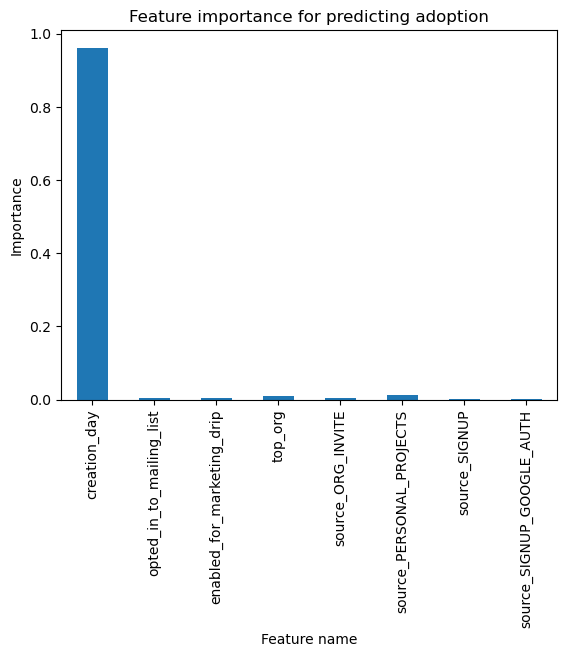

In [130]:
forest2_importances.plot(kind='bar')
plt.title('Feature importance for predicting adoption')
plt.xlabel('Feature name')
plt.ylabel('Importance')
plt.show()

The model's scores are now more plausible, but it's based almost entirely on the day of account creation. Let's try one more without either date feature.

In [131]:
predictive_columns.remove('creation_day')

In [133]:
X_train = X_train.drop('creation_day',axis=1)
X_test = X_test.drop('creation_day',axis=1)

In [134]:
forest3 = RandomForestClassifier(random_state=42)

In [135]:
clf = RandomizedSearchCV(forest3, paramgrid, random_state=42,n_iter=20,scoring='f1',verbose=3)

In [ ]:
search = clf.fit(X_train,y_train)

In [137]:
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': False}

In [138]:
forest3 = RandomForestClassifier(random_state=42,n_estimators=200,min_samples_split=5,
                                 min_samples_leaf=4,max_features=None,max_depth=10,bootstrap=False)

In [139]:
forest3.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=None,
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [140]:
y_pred = forest3.predict(X_test)

In [142]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2074
           1       0.00      0.00      0.00       326

    accuracy                           0.86      2400
   macro avg       0.43      0.50      0.46      2400
weighted avg       0.75      0.86      0.80      2400



C:\Users\emily\miniconda3\envs\ultimate\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emily\miniconda3\envs\ultimate\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emily\miniconda3\envs\ultimate\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
# Checking that the classification report is saying what I think it's saying
y_pred.sum()

0

This time, the model just played it safe and predicted a 0 for everything. Ouch! That's not good at all. Let's try a different model entirely.

In [144]:
from sklearn.neighbors import KNeighborsClassifier

In [145]:
knn = KNeighborsClassifier()

In [152]:
clf = RandomizedSearchCV(knn, {'n_neighbors':list(range(1,31))},random_state=42,scoring='f1',verbose=3,n_iter=10)

In [ ]:
search = clf.fit(X_train,y_train)

In [154]:
search.best_params_

{'n_neighbors': 1}

In [156]:
knn = KNeighborsClassifier(n_neighbors=1)

In [157]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [158]:
y_pred = knn.predict(X_test)

In [159]:
y_pred.sum()

26

In [161]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2074
           1       0.12      0.01      0.02       326

    accuracy                           0.86      2400
   macro avg       0.49      0.50      0.47      2400
weighted avg       0.76      0.86      0.80      2400



Well, this is better than guessing all 0 for everything, but only nominally. I suppose the date of creation and the date of last session simply are the only really significant predictive features. Not very satisfying, but on the upside, we should be able to get a very interpretable decision tree.

In [164]:
# Getting the dropped data back. 
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [162]:
from sklearn.tree import DecisionTreeClassifier

In [178]:
tree = DecisionTreeClassifier(random_state=42,max_depth=4)

In [179]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [180]:
y_pred = tree.predict(X_test)

In [181]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2074
           1       0.95      0.89      0.92       326

    accuracy                           0.98      2400
   macro avg       0.97      0.94      0.95      2400
weighted avg       0.98      0.98      0.98      2400



In [182]:
from sklearn.tree import plot_tree

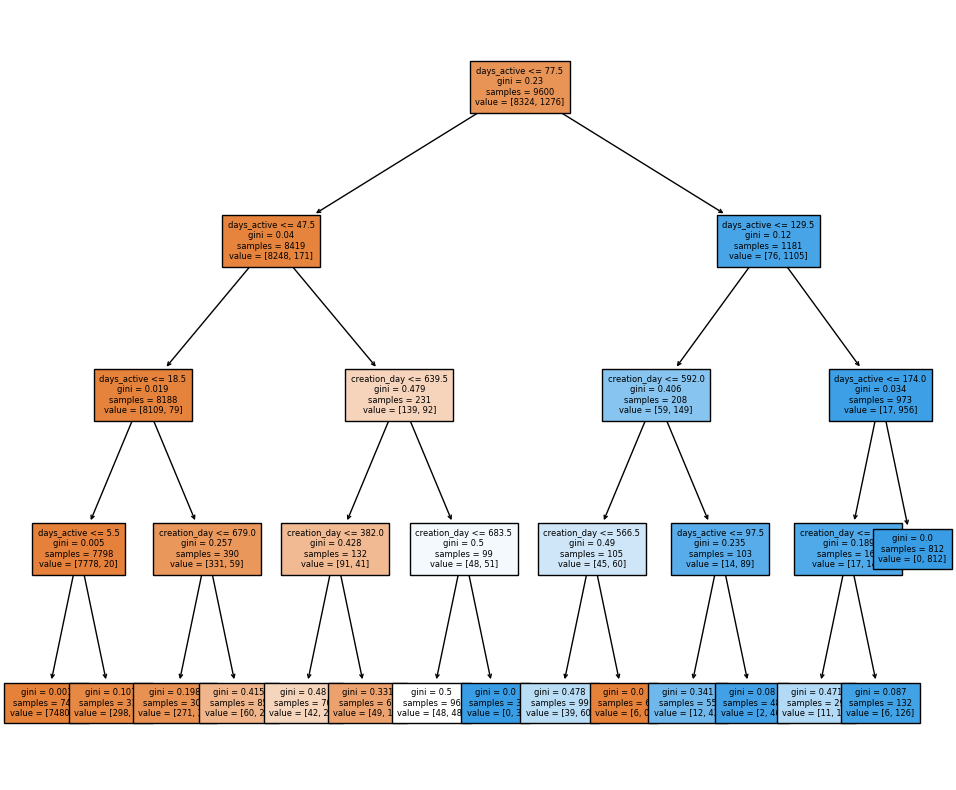

In [187]:
plt.figure(figsize=(12,10))
plot_tree(tree,fontsize=6,filled=True,feature_names=X_train.columns)
plt.show()

Sure enough, the only two features considered by the decision tree are when the account was created (earlier is better) and how long the account was active (longer is better). Let's check some details. 

In [195]:
mean_creation_adopt = full_users[full_users['adopted']==1]['creation_day'].mean()
mean_creation_no = full_users[full_users['adopted']==0]['creation_day'].mean()
mean_active_adopt = full_users[full_users['adopted']==1]['days_active'].mean()
mean_active_no = full_users[full_users['adopted']==0]['days_active'].mean()

In [199]:
print(f"The mean number of days between the creation of the first account, and the creation of each adopted user's account,\
 is {round(mean_creation_adopt)} days, compared to {round(mean_creation_no)} for non-adopted users.")
print(f"Incredibly, the mean number of days between account creation and date of last activity is \
{round(mean_active_adopt)} for adopted users, compared to a mere {round(mean_active_no)} for non-adopted users.")

The mean number of days between the creation of the first account, and the creation of each adopted user's account is 362 days, compared to 419 for non-adopted users.
Incredibly, the mean number of days between account creation and date of last activity is 300 for adopted users, compared to a mere 4 for non-adopted users.


In [202]:
full_users[full_users['adopted']==1].describe()

,index,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,time_active,days_active,creation_day
count,1602.000000,1602.000000,1602,1602,1602.000000,1602.000000,1602.000000,1602.000000,1602.0,1602,1602.000000,1602.000000
mean,6050.244070,6051.244070,2013-05-28 23:41:28.670412032,2014-03-25 04:30:54.962546944,0.258427,0.153558,162.276529,3401.558677,1.0,300 days 04:49:26.292134832,300.200999,362.458801
min,1.000000,2.000000,2012-05-31 21:58:33,2012-07-06 13:46:16,0.000000,0.000000,0.000000,0.000000,1.0,4 days 00:00:00,4.000000,0.000000
25%,3075.250000,3076.250000,2012-12-04 15:43:20.750000128,2014-05-15 10:33:44,0.000000,0.000000,52.000000,0.000000,1.0,129 days 00:00:00,129.000000,187.000000
50%,6023.500000,6024.500000,2013-06-06 17:24:37.500000,2014-05-28 22:14:58.500000,0.000000,0.000000,140.500000,1699.000000,1.0,250 days 00:00:00,250.000000,371.000000
75%,9105.250000,9106.250000,2013-11-18 09:45:06.249999872,2014-06-03 15:38:01.249999872,1.000000,0.000000,264.000000,6582.500000,1.0,469 days 12:00:00,469.500000,536.000000
max,11987.000000,11988.000000,2014-05-18 22:08:05,2014-06-04 23:56:26,1.000000,1.000000,415.000000,11994.000000,1.0,729 days 00:00:00,729.000000,717.000000
std,3474.521279,3474.521279,NaN,NaN,0.437907,0.360637,122.785901,3879.788422,0.0,205 days 18:06:47.360798948,205.754715,201.490058


In [203]:
full_users[full_users['adopted']==0].describe()

,index,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,time_active,days_active,creation_day
count,10398.000000,10398.000000,10398,7221,10398.000000,10398.000000,10398.000000,10398.000000,10398.0,7221,10398.000000,10398.000000
mean,5991.681958,5992.681958,2013-07-24 01:01:41.935372288,2013-08-04 15:51:17.987120896,0.248125,0.148682,138.742835,3155.895268,0.0,5 days 18:14:48.408807644,3.694749,418.512214
min,0.000000,1.000000,2012-05-31 00:43:27,2012-05-31 08:20:06,0.000000,0.000000,0.000000,0.000000,0.0,0 days 00:00:00,-1.000000,0.000000
25%,2981.250000,2982.250000,2013-01-22 08:55:11,2013-02-04 18:11:29,0.000000,0.000000,26.000000,0.000000,0.0,0 days 00:00:00,-1.000000,236.000000
50%,5998.500000,5999.500000,2013-08-14 01:30:03,2013-08-29 11:50:02,0.000000,0.000000,103.000000,730.000000,0.0,1 days 00:00:00,0.000000,439.500000
75%,8985.750000,8986.750000,2014-02-09 16:31:26.500000,2014-02-21 17:01:51,0.000000,0.000000,234.000000,6304.000000,0.0,2 days 00:00:00,1.000000,619.000000
max,11999.000000,12000.000000,2014-05-30 23:59:19,2014-06-06 14:58:50,1.000000,1.000000,416.000000,11999.000000,0.0,251 days 00:00:00,251.000000,729.000000
std,3462.761532,3462.761532,NaN,NaN,0.431945,0.355792,123.959313,3866.512335,0.0,16 days 07:47:19.476095485,13.955546,217.931443
